-------- Wyniki dla zbioru nr 0 --------
Accuracy: 0.8936127791330456
Sensitivity: 0.5358932461873638
Specificity: 0.936773828925924
Negative predictive value: 0.9435949373791934
Precision: 0.505601233299075
Średnie wyniki dla tego rozwiązania
średnie accuracy: 0.8936127791330456
średnie sensitivity: 0.5358932461873638
średnie specificity: 0.936773828925924
średnie negative predictive value: 0.9435949373791934
średnie precision: 0.505601233299075


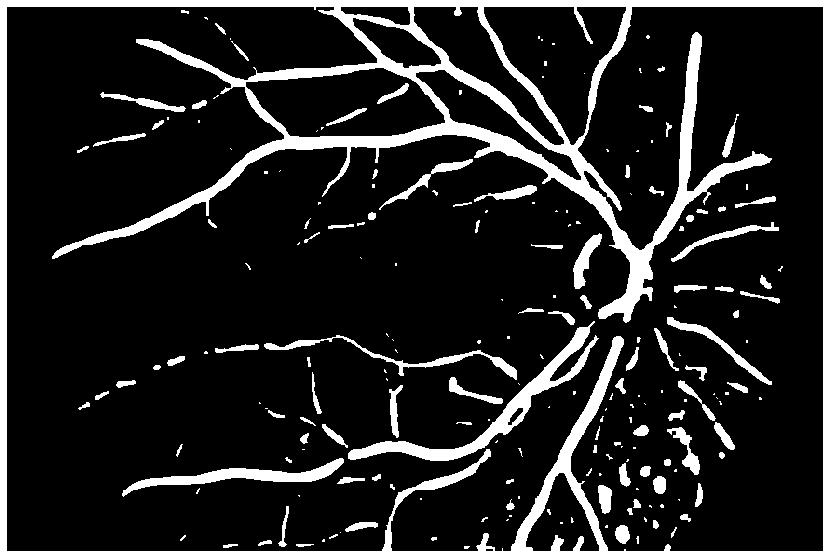

In [46]:
from matplotlib import pylab as plt
from skimage.filters import frangi
import numpy as np 
import cv2

def copy2dArrayFragment(array, x, y, r):
    res = []
    height, width = array.shape
    for i in range(height):
        for j in range(width):
            if j == x - r and i >= y-r and i <= y+r:
                res.append([])
            if j >= x - r and j <= x + r and i >= y - r and i <= y + r:
                res[i - (y - r)].append(array[i,j])
    return res

def removeEyeLens(detectFrom, output, max_circle_radius, eye_lens_offset):
    res = output.copy()
    detected_circles = cv2.HoughCircles(detectFrom,  
                                        cv2.HOUGH_GRADIENT, 1, 20, 
                                        param1 = 50, 
                                        param2 = 30,
                                        minRadius = 1, 
                                        maxRadius = max_circle_radius) 

    if detected_circles is not None: 
        detected_circles = np.uint16(np.around(detected_circles)) 
        # todo
        # for pt in detected_circles[0, :]: 
        pt = detected_circles[0][0]
        a, b, r = pt[0], pt[1], pt[2] 

        gray_values = []

        # wyznacz wartosc 10-tego percentyla, aby pozostawic ciemniejsze
        # miejsca (zyly)
        height, width = res.shape
        for i in range(height):
            for j in range(width):
                d = np.sqrt((j-a)**2 + (i-b)**2) - r
                if d < eye_lens_offset and d > 0:
                    gray_values.append(detectFrom[i, j])

        percentile_value = np.percentile(gray_values, 10)

        # odetnij z wynikowego obrazka wszystko, co znajduje sie w odleglosci
        # 20 poza kolem i jego szarosc nie miesci sie w percentylu
        for i in range(height):
            for j in range(width):
                d = np.sqrt((j-a)**2 + (i-b)**2) - r
                if d < 20 and d > 0 and detectFrom[i, j] > percentile_value:
                    res[i,j] = 255
        
    return res

# img_path = 'datasets/chase/Image_01L.jpg'
# ground_truth_path = 'datasets/chase/labeled-1st/Image_01L_1stHO.jpg'
ground_truth_paths = [
#                       'datasets/hrf/labeled/01_h.tif',
#                       'datasets/hrf/labeled/02_h.tif',
#                       'datasets/hrf/labeled/03_h.tif',
                      'datasets/hrf/labeled/04_h.tif',
                      'datasets/hrf/labeled/05_h.tif',
                      'datasets/hrf/labeled/06_h.tif',
                      'datasets/hrf/labeled/07_h.tif',
                      'datasets/hrf/labeled/08_h.tif',
                      'datasets/hrf/labeled/09_h.tif',
                      'datasets/hrf/labeled/10_h.tif'
                     ]
img_paths = [
#              'datasets/hrf/01_h.jpg', 
#              'datasets/hrf/02_h.jpg',
#              'datasets/hrf/03_h.jpg',
             'datasets/hrf/04_h.jpg',
             'datasets/hrf/05_h.jpg',
             'datasets/hrf/06_h.jpg',
             'datasets/hrf/07_h.jpg',
             'datasets/hrf/08_h.jpg',
             'datasets/hrf/09_h.jpg',
             'datasets/hrf/10_h.jpg'
            ]

max_circle_radius = 50
eye_lens_offset = 40
resize_image_coeff = 0.25
avg_accuracy = avg_sensitivity = avg_specificity = avg_negative = avg_precision = 0

curr = 0

for curr in range(1):#range(len(img_paths)):
    comparsion = []
    
    # wczytaj zdjecie ground truth
    img_ground = cv2.imread(ground_truth_paths[curr])
    img_ground = cv2.resize(img_ground, (0,0), fx=resize_image_coeff, fy=resize_image_coeff) 
    img_ground = cv2.cvtColor(img_ground, cv2.COLOR_BGR2GRAY)
    
    # odczytanie i wstepne przetworzenie zdjecia
    original = cv2.imread(img_paths[curr])
    resized = cv2.resize(original, (0,0), fx=resize_image_coeff, fy=resize_image_coeff) 
    img = gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    img = cv2.blur(gray, (3, 3))

    # threshold
    img = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 51, 7)

    # usuniecie linii z soczewki oka
    img = removeEyeLens(gray, img, max_circle_radius, eye_lens_offset)

    # usun ramke
    height, width, depth = resized.shape
    for i in range(0, height):  
        for j in range(0, width): 
            if resized[i, j, 0] < 10 and resized[i, j, 1] < 10 and resized[i, j, 2] < 10:
                img[i,j] = 255
                
    # usun linie dookola ramki, pogrub krawedzie
#     kernel = np.ones((3,3), np.uint8)
#     img = cv2.erode(img, kernel, iterations=1)
    kernel = np.ones((2,2), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)

    # filtr frangi
    img=(frangi(img))

    # polacz kropki
    kernel = np.ones((4,4), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    height, width = img.shape
    for i in range(0, height):
        row_comparsion = []
        
        for j in range(0, width):
            
            isVessel = False
            if (img_ground[i,j] != 0.0):
                isVessel = True
            
            if img[i, j] > 0.00001:
                img[i,j] = 1.0
                if(isVessel == True):
                    row_comparsion.append(np.array([255, 255, 255]))
                else:
                    row_comparsion.append(np.array([255, 0, 0]))
            else:
                img[i, j] = 0.0
                if(isVessel != True):
                    row_comparsion.append(np.array([0, 0, 0]))
                else:
                    row_comparsion.append(np.array([0, 255, 0]))
            
            comparsion.append(np.array(row_comparsion))

    plt.figure(figsize=(20,10))
    plt.subplot(1, 1, 1)
    plt.axis('off')
    plt.imshow(img, cmap="gray")
    plt.savefig("results/digital-result-" + str(curr + 3) + '.png', bbox_inches='tight')
    
    comparsion = np.array(comparsion)
    
    plt.axis('off')
#     plt.imshow(comparsion)
    plt.savefig("results/digital-compare-" + str(curr + 3) + '.png', bbox_inches='tight')

    # sklasyfikuj sensitivity, specificity
    positive_all = 0
    negative_all = 0
    positive_true = 0
    negative_true = 0
    positive_false = 0
    negative_false = 0

    height, width = img_ground.shape

    for i in range(0, height):  
        for j in range(0, width): 
            if img_ground[i,j] == 0.0:
                negative_all += 1
                if img[i, j] == 0:
                    negative_true += 1
                else: 
                    negative_false += 1
            else: 
                positive_all += 1
                if img[i,j] == 1:
                    positive_true += 1
                else: 
                    positive_false += 1

    acc = (positive_true + negative_true)/(positive_all + negative_all)
    
    sen = positive_true / (positive_true + negative_false)
    spec = negative_true / (negative_true + positive_false)
    
    neg = negative_true / (negative_true + negative_false)
    prec = positive_true / (positive_true + positive_false)
    
    avg_accuracy += acc
    avg_sensitivity += sen
    avg_specificity += spec
    avg_negative += neg
    avg_precision += prec
    
    print("--------" + " Wyniki dla zbioru nr " + str(curr) + " --------")
    print("Accuracy: " + str(acc))

    print("Sensitivity: " + str(sen))
    print("Specificity: " + str(spec))

    print("Negative predictive value: " + str(neg))    
    print("Precision: " + str(prec))
    
curr += 1

print("Średnie wyniki dla tego rozwiązania")
print("średnie accuracy: " + str(avg_accuracy/curr))
print("średnie sensitivity: " + str(avg_sensitivity/curr))
print("średnie specificity: " + str(avg_specificity/curr))
print("średnie negative predictive value: " + str(avg_negative/curr))
print("średnie precision: " + str(avg_precision/curr))
#     print("--------" + " Obrazek nr " + str(0) + " --------")
#     print("Accuracy: " + str((positive_true + negative_true)/(positive_all + negative_all)))
    
#     print("True positive (sensitivity / precision): " + str(positive_true) + " / " + str(positive_all) + " = " + str((positive_true / positive_all)))
#     print("True negative (specificity): " + str(negative_true) + " / " + str(negative_all) + " = " + str((negative_true / negative_all)))
    
#     print("Recall: " + str(positive_true / (positive_true + negative_false)))

# # pokaż obrazki
# plt.figure(figsize=(20,10))
# plt.subplot(2, 2, 1)
# plt.imshow(img, cmap="gray")

# plt.subplot(2, 2, 2)
# plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))

In [52]:
comparsion = []
height, width = img.shape
for i in range(0, height // 8):
    row_comparsion = []

    for j in range(0, width // 8):

        isVessel = False
        if (img_ground[i,j] != 0.0):
            isVessel = True
        print(img[i,j])
        if img[i, j] > 0.00001:
            img[i,j] = 1.0
            if(isVessel == True):
                row_comparsion.append(np.array([255, 255, 255]))
            else:
                row_comparsion.append(np.array([255, 0, 0]))
        else:
            img[i, j] = 0.0
            if(isVessel != True):
                row_comparsion.append(np.array([0, 0, 0]))
            else:
                row_comparsion.append(np.array([0, 255, 0]))

        comparsion.append(np.array(row_comparsion))
    
comparsion = np.array(comparsion)
print(comparsion)  
# plt.axis('off')
# # print(comparsion)
# plt.imshow(comparsion)
# plt.savefig("results/digital-compare-" + str(1) + '.png', bbox_inches='tight')

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


-------- Obrazek nr 0 --------
True positive (sensitivity): 23875 / 53708 = 0.4445334028450138
True negative (specificity): 436789 / 457876 = 0.953946046527881
-------- Obrazek nr 1 --------
True positive (sensitivity): 26465 / 56254 = 0.47045543428022896
True negative (specificity): 429805 / 455330 = 0.9439417565282323
-------- Obrazek nr 2 --------
True positive (sensitivity): 22010 / 59586 = 0.36938206961366765
True negative (specificity): 432250 / 451998 = 0.9563095411926601
-------- Obrazek nr 3 --------
True positive (sensitivity): 26555 / 58380 = 0.4548646796848236
True negative (specificity): 431208 / 453204 = 0.9514655651759473
-------- Obrazek nr 4 --------
True positive (sensitivity): 19598 / 51497 = 0.38056585820533234
True negative (specificity): 445770 / 460087 = 0.968881972322626
-------- Obrazek nr 5 --------
True positive (sensitivity): 26462 / 58289 = 0.453979309989878
True negative (specificity): 432035 / 453295 = 0.9530989752809981
-------- Obrazek nr 6 --------
Tru

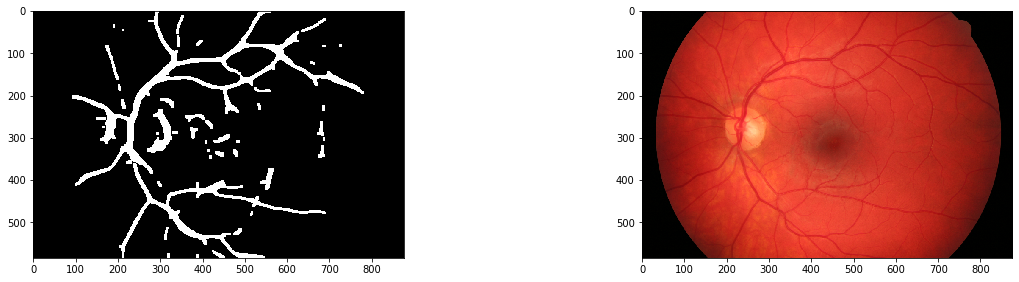

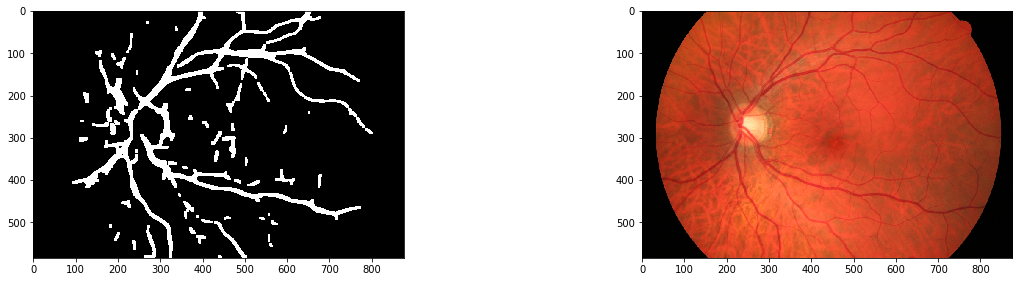

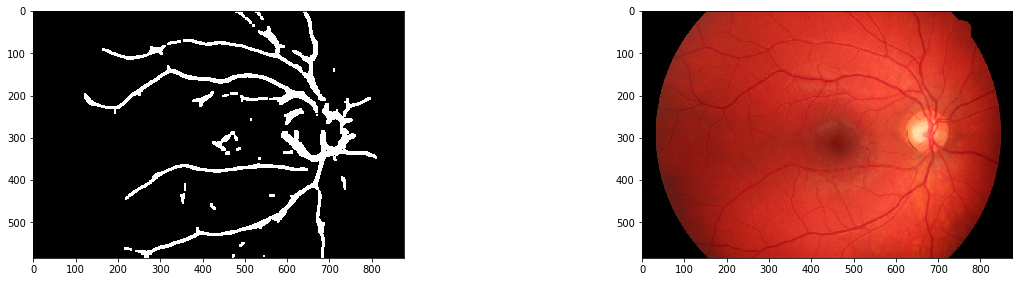

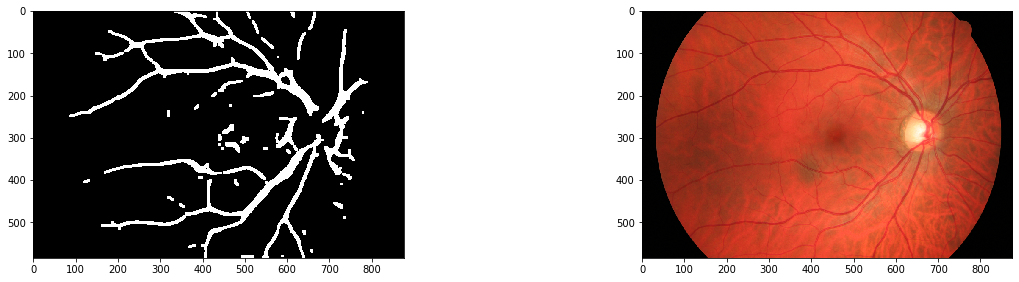

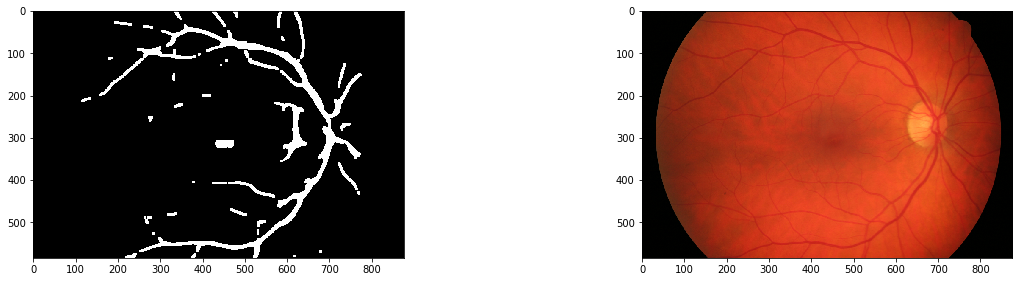

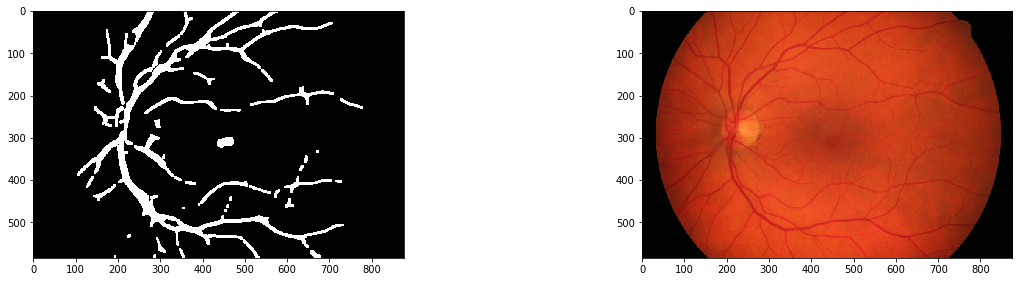

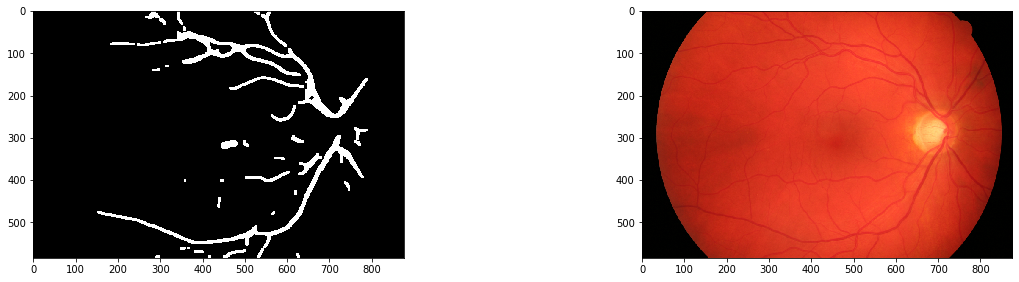

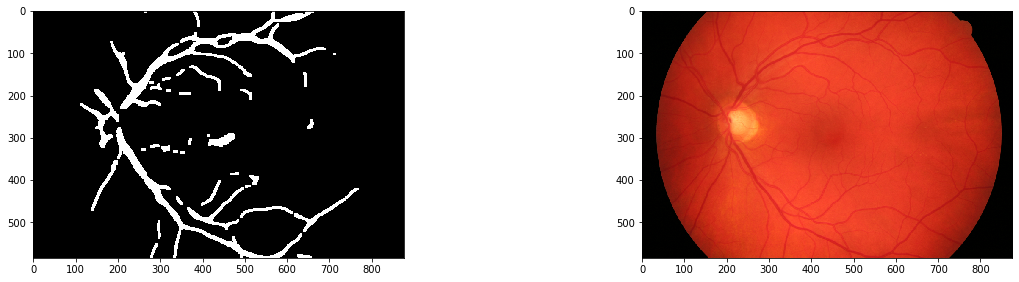

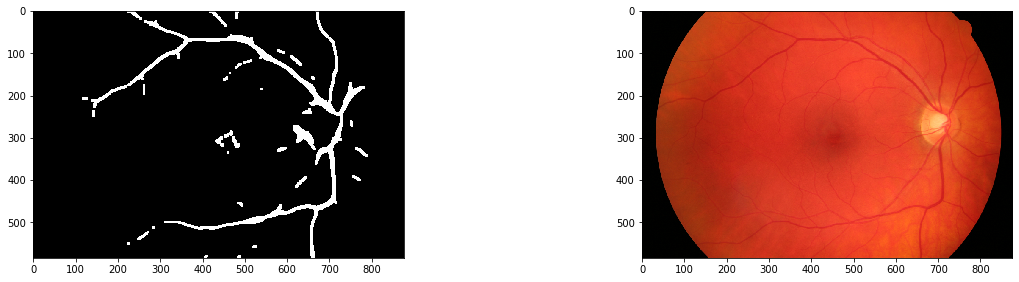

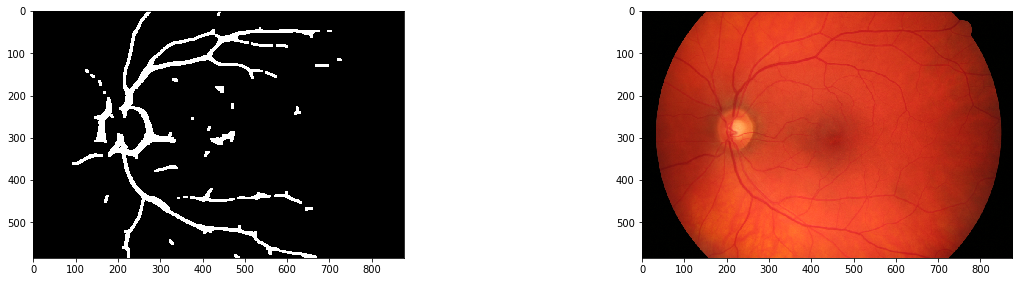

In [20]:
from matplotlib import pylab as plt
import skimage.morphology as mp
from skimage.filters import frangi, hessian
import numpy as np 
import cv2

# img_path = 'datasets/chase/Image_01L.jpg'
# ground_truth_path = 'datasets/chase/labeled-1st/Image_01L_1stHO.jpg'
ground_truth_paths = ['datasets/hrf/labeled/01_h.tif',
                      'datasets/hrf/labeled/02_h.tif',
                      'datasets/hrf/labeled/03_h.tif',
                      'datasets/hrf/labeled/04_h.tif',
                      'datasets/hrf/labeled/05_h.tif',
                      'datasets/hrf/labeled/06_h.tif',
                      'datasets/hrf/labeled/07_h.tif',
                      'datasets/hrf/labeled/08_h.tif',
                      'datasets/hrf/labeled/09_h.tif',
                      'datasets/hrf/labeled/10_h.tif'
                     ]
img_paths = ['datasets/hrf/01_h.jpg', 
             'datasets/hrf/02_h.jpg',
             'datasets/hrf/03_h.jpg',
             'datasets/hrf/04_h.jpg',
             'datasets/hrf/05_h.jpg',
             'datasets/hrf/06_h.jpg',
             'datasets/hrf/07_h.jpg',
             'datasets/hrf/08_h.jpg',
             'datasets/hrf/09_h.jpg',
             'datasets/hrf/10_h.jpg'
            ]

for l in range(len(img_paths)):
    # odczytaj zdjecie, pomniejsz i sformatuj do koloru szarego
    original = cv2.imread(img_paths[l])
    resized = cv2.resize(original, (0,0), fx=0.25, fy=0.25) 
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

    #kontrast
    img = cv2.convertScaleAbs(gray, alpha=1, beta=70)

    # polacz kropki
    kernel = np.ones((15,15), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    # threshold
    tresh = img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 7)

    # usun ramke
    height, width, depth = resized.shape
    for i in range(0, height):  
        for j in range(0, width): 
            if resized[i, j, 0] < 10 and resized[i, j, 1] < 10 and resized[i, j, 2] < 10:
                img[i,j] = 255


    # filtr frangi
    img=(frangi(img, gamma = 15))

    height, width = img.shape
    for i in range(0, height):  
        for j in range(0, width): 
            if img[i, j] > 0.0001:
                img[i,j] = 1.0
            else:
                img[i, j] = 0.0


    # usun linie dookola ramki, pogrub krawedzie
    kernel = np.ones((3,3), np.uint8)
    img = cv2.erode(img, kernel, iterations=1)
    kernel = np.ones((6,6), np.uint8)
    img = cv2.dilate(img, kernel, iterations=1)

    # wczytaj zdjecie ground truth
    img_ground = cv2.imread(ground_truth_paths[l])
    img_ground = cv2.resize(img_ground, (0,0), fx=0.25, fy=0.25) 
    img_ground = cv2.cvtColor(img_ground, cv2.COLOR_BGR2GRAY)

    # sklasyfikuj sensitivity, specificity
    positive_all = 0
    negative_all = 0
    positive_classified = 0
    negative_classified = 0

    height, width = img_ground.shape

    for i in range(0, height):  
        for j in range(0, width): 
            if img_ground[i,j] == 0.0:
                negative_all += 1
                if img[i, j] == 0:
                    negative_classified += 1
            else: 
                positive_all += 1
                if img[i,j] == 1:
                    positive_classified += 1

    print("--------" + " Obrazek nr " + str(l) + " --------")
    print("True positive (sensitivity): " + str(positive_classified) + " / " + str(positive_all) + " = " + str((positive_classified / positive_all)))
    print("True negative (specificity): " + str(negative_classified) + " / " + str(negative_all) + " = " + str((negative_classified / negative_all)))

    # pokaż obrazki
    plt.figure(figsize=(20,10))
    plt.subplot(2, 2, 1)
    plt.imshow(img, cmap="gray")

    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))